In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split
import kagglehub as kh
from sklearn.metrics import confusion_matrix

NORMALIZE_COUNTS = True

/home/koris/Documents/GitHub/MusicAnalysis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import r2_score

def adjr2(pred, test, p):
    r2 = r2_score(test, pred)
    n = len(test)
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

### Oversample Missing Data

In [3]:
path = kh.dataset_download("uciml/msd-audio-features")
print("Path to dataset files:", path)
data_by_decade = pd.read_csv(path + "/year_prediction.csv")
# data_by_ear doesn't have the year labels squashed into decades
data_by_year = pd.read_csv(path + "/year_prediction.csv")

# check for NA
data_dropped = data_by_decade.dropna()
if len(data_dropped) == len(data_by_decade):
    print("No NA")

def convert_year(year):
    year_str = str(int(year["label"]))
    year_str = year_str[:-1] + '0'
    year_str += 's'
    return year_str

data_by_decade["label"] = data_by_decade.apply(convert_year, axis=1)

labels_trim = data_by_decade["label"]
labels_trim = labels_trim.replace({"2010s": "2000s"})
labels_trim = labels_trim.replace({"2000s": "2000s"})
labels_trim = labels_trim.replace({"1990s": "1990s"})
labels_trim = labels_trim.replace({"1980s": "1980s"})
labels_trim = labels_trim.replace({"1970s": "1970s"})
labels_trim = labels_trim.replace({"1960s": "<=1960s"})
labels_trim = labels_trim.replace({"1950s":  "<=1960s"})
labels_trim = labels_trim.replace({"1940s": "<=1960s"})
labels_trim = labels_trim.replace({"1930s":  "<=1960s"})
labels_trim = labels_trim.replace({"1920s":  "<=1960s"})
data_by_decade["label"] = labels_trim

data_by_decade, true_test = train_test_split(data_by_decade, train_size=0.7, random_state=42, stratify=data_by_decade["label"])


Path to dataset files: /home/koris/.cache/kagglehub/datasets/uciml/msd-audio-features/versions/1
No NA


In [4]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X, y = oversample.fit_resample(data_by_decade.drop(['label'], axis=1), data_by_decade['label'])

In [5]:
df_upsampled = X
df_upsampled["label"] = y
df_upsampled_2000s = df_upsampled[df_upsampled["label"] == "2000s"]
df_upsampled_1990s = df_upsampled[df_upsampled["label"] == "1990s"]
df_upsampled_1980s = df_upsampled[df_upsampled["label"] == "1980s"]
df_upsampled_1970s = df_upsampled[df_upsampled["label"] == "1970s"]
df_upsampled_1960s_and_less = df_upsampled[df_upsampled["label"] == "<=1960s"]

col_names = data_by_decade.drop("label", axis=1).columns.to_list()

df_2000s = data_by_decade[data_by_decade["label"] == "2000s"]
df_1990s = data_by_decade[data_by_decade["label"] == "1990s"]
df_1980s = data_by_decade[data_by_decade["label"] == "1980s"]
df_1970s = data_by_decade[data_by_decade["label"] == "1970s"]
df_1960s_and_less = data_by_decade[data_by_decade["label"] == "<=1960s"]

target_count = 100000

if len(df_2000s) <= target_count:
    df_2000s = pd.concat([df_2000s, df_upsampled_2000s.sample(target_count - len(df_2000s))], axis=0)

if len(df_1990s) <= target_count:
    df_1990s = pd.concat([df_1990s, df_upsampled_1990s.sample(target_count - len(df_1990s))], axis=0)

if len(df_1980s) <= target_count:
    df_1980s = pd.concat([df_1980s, df_upsampled_1980s.sample(target_count - len(df_1980s))], axis=0)

if len(df_1970s) <= target_count:
    df_1970s = pd.concat([df_1970s, df_upsampled_1970s.sample(target_count - len(df_1970s))], axis=0)

if len(df_1960s_and_less) <= target_count:
    df_1960s_and_less = pd.concat([df_1960s_and_less, df_upsampled_1960s_and_less.sample(target_count - len(df_1960s_and_less))], axis=0)

complete = pd.concat([df_2000s, df_1990s, df_1980s, df_1970s, df_1960s_and_less], axis=0)

In [6]:
data_by_decade = complete

In [7]:
train = data_by_decade
train_label = train["label"].astype("category").cat.codes
train.drop("label", axis=1, inplace=True)

from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

Learning rate set to 0.240625
0:	learn: 1.4978702	total: 57.7ms	remaining: 57.7s
1:	learn: 1.4401085	total: 80.4ms	remaining: 40.1s
2:	learn: 1.3977757	total: 104ms	remaining: 34.5s
3:	learn: 1.3674473	total: 126ms	remaining: 31.4s
4:	learn: 1.3408021	total: 149ms	remaining: 29.7s
5:	learn: 1.3199200	total: 172ms	remaining: 28.6s
6:	learn: 1.3019597	total: 195ms	remaining: 27.7s
7:	learn: 1.2864586	total: 214ms	remaining: 26.5s
8:	learn: 1.2727958	total: 231ms	remaining: 25.5s
9:	learn: 1.2600692	total: 252ms	remaining: 25s
10:	learn: 1.2495482	total: 272ms	remaining: 24.4s
11:	learn: 1.2397229	total: 291ms	remaining: 23.9s
12:	learn: 1.2304979	total: 310ms	remaining: 23.6s
13:	learn: 1.2212667	total: 329ms	remaining: 23.1s
14:	learn: 1.2139740	total: 496ms	remaining: 32.5s
15:	learn: 1.2068199	total: 516ms	remaining: 31.7s
16:	learn: 1.2001404	total: 534ms	remaining: 30.9s
17:	learn: 1.1938306	total: 553ms	remaining: 30.2s
18:	learn: 1.1869773	total: 573ms	remaining: 29.6s
19:	learn: 

0.6459858735867119


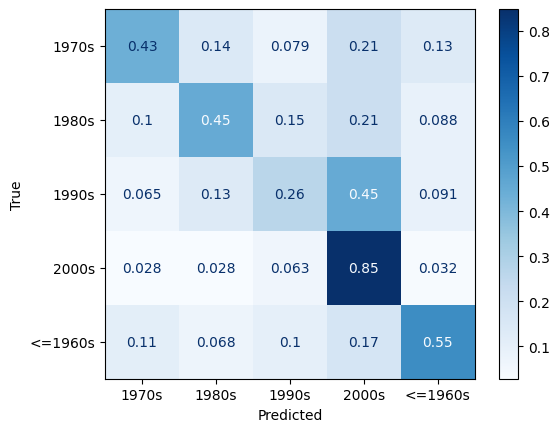

In [ ]:
label_lookup = dict(enumerate(true_test['label'].astype("category").cat.categories))
true_test_labels = true_test["label"].astype("category").cat.codes
true_test.drop("label", axis=1, inplace=True)

# CATBOOST ACCURACY
pred = cat_model.predict(true_test)
test_label_list = true_test_labels.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)

matrix = confusion_matrix(true_test_labels, pred)
matrix = matrix.astype('float') / matrix.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()